In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import xml.etree.ElementTree as ET
import os
import numpy as np

# Basit CNN Modeli
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 1024)  # Görüntü boyutuna göre güncellenebilir
        self.fc2 = nn.Linear(1024, 4)  # 4 çıktı: xmin, ymin, xmax, ymax
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = torch.max_pool2d(torch.relu(self.conv3(x)), kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # ROI koordinatlarını tahmin et
        return x

# Dataset Sınıfı
class MammogramDataset(Dataset):
    def __init__(self, image_dir, xml_dir, transform=None):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.xml_files = sorted(os.listdir(xml_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        xml_path = os.path.join(self.xml_dir, self.xml_files[idx])

        image = Image.open(image_path).convert("L")
        tree = ET.parse(xml_path)
        root = tree.getroot()

        bboxes = []
        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            bboxes = [xmin, ymin, xmax, ymax]
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(bboxes, dtype=torch.float32)

# Transformlar ve Veri Yükleme
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Siyah-beyaz görüntü
    transforms.Resize((224, 224)),  # 224x224 boyutuna yeniden boyutlandırma
    transforms.ToTensor(),  # Tensor formatına dönüştürme
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizasyon
])

image_dir = 'C:\\Users\\Asus\\Desktop\\ROI_Model_Work\\Augementation\\rotated_data'
xml_dir = 'C:\\Users\\Asus\\Desktop\\ROI_Model_Work\\labeled_breast'

dataset = MammogramDataset(image_dir=image_dir, xml_dir=xml_dir, transform=transform)

# Eğitim ve Test Veri Setlerine Ayırma
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# CUDA desteği: GPU'ya geçiş
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss ve optimizasyon
model = SimpleCNN(num_classes=1).to(device)  # Modeli CUDA'ya taşıyoruz
criterion = nn.MSELoss()  # Bounding box regresyonu için MSE loss kullanılıyor
optimizer = optim.Adam(model.parameters(), lr=0.001)

# IoU Hesaplama Fonksiyonu
def iou(pred_bbox, true_bbox):
    # Intersection over Union hesaplama
    x1, y1, x2, y2 = pred_bbox
    x1_gt, y1_gt, x2_gt, y2_gt = true_bbox

    # Koordinatların kesişim alanını hesaplayalım
    xi1 = max(x1, x1_gt)
    yi1 = max(y1, y1_gt)
    xi2 = min(x2, x2_gt)
    yi2 = min(y2, y2_gt)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    pred_area = (x2 - x1) * (y2 - y1)
    true_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)

    iou_score = inter_area / (pred_area + true_area - inter_area)
    return iou_score

# Eğitim Döngüsü
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # IoU'yu hesapla
        for output, target in zip(outputs, targets):
            iou_score = iou(output.detach().cpu().numpy(), target.detach().cpu().numpy())
            total_iou += iou_score
            total_samples += 1

    avg_loss = running_loss / len(train_dataloader)
    avg_iou = total_iou / total_samples
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}')

# Modeli Test Etme (Test Veri Seti)
def test_model(model, dataloader, device):
    model.eval()  # Modeli değerlendirme moduna alıyoruz
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():  # Değerlendirme sırasında gradyan hesaplamasını durduruyoruz
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            # Modelden tahminleri al
            outputs = model(images)

            # IoU'yu hesapla
            for output, target in zip(outputs, targets):
                iou_score = iou(output.detach().cpu().numpy(), target.detach().cpu().numpy())
                total_iou += iou_score
                total_samples += 1

    avg_iou = total_iou / total_samples
    print(f'Avg IoU on Test Set: {avg_iou:.4f}')
    return avg_iou

# Testi başlatın
avg_iou = test_model(model, test_dataloader, device)

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")   

Epoch 1/30, Loss: 1039297.4880, Avg IoU: 0.3302
Epoch 2/30, Loss: 508439.5635, Avg IoU: 0.4528
Epoch 3/30, Loss: 326166.0847, Avg IoU: 0.5241
Epoch 4/30, Loss: 272028.3126, Avg IoU: 0.5587
Epoch 5/30, Loss: 257479.9517, Avg IoU: 0.5676
Epoch 6/30, Loss: 200753.4562, Avg IoU: 0.6106
Epoch 7/30, Loss: 210444.0379, Avg IoU: 0.6072
Epoch 8/30, Loss: 184616.7962, Avg IoU: 0.6132
Epoch 9/30, Loss: 179728.1529, Avg IoU: 0.6264
Epoch 10/30, Loss: 173345.4488, Avg IoU: 0.6362
Epoch 11/30, Loss: 137661.1271, Avg IoU: 0.6559
Epoch 12/30, Loss: 109114.8370, Avg IoU: 0.6746
Epoch 13/30, Loss: 100804.3009, Avg IoU: 0.7034
Epoch 14/30, Loss: 98004.6977, Avg IoU: 0.7144
Epoch 15/30, Loss: 94350.3548, Avg IoU: 0.7031
Epoch 16/30, Loss: 81230.7816, Avg IoU: 0.7223
Epoch 17/30, Loss: 75845.7687, Avg IoU: 0.7283
Epoch 18/30, Loss: 57777.5124, Avg IoU: 0.7568
Epoch 19/30, Loss: 37968.3405, Avg IoU: 0.7842
Epoch 20/30, Loss: 22884.5530, Avg IoU: 0.8365
Epoch 21/30, Loss: 26769.6263, Avg IoU: 0.8221
Epoch 22

In [2]:
import matplotlib.pyplot as plt

In [9]:
print("True BBox:", true_bbox)
print("Predicted BBox:", predicted_bbox)


True BBox: [  1120.  61376. 231616. 596512.]
Predicted BBox: [-10429.90771484 112868.15039062 275193.3515625  702764.78125   ]


In [11]:
image_h, image_w = image.shape[:2]
true_bbox = true_bbox * [image_w, image_h, image_w, image_h]
predicted_bbox = predicted_bbox * [image_w, image_h, image_w, image_h]

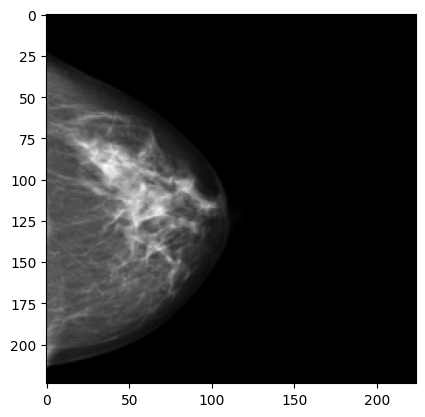

In [12]:
# Görüntüyü çiz
plt.imshow(image, cmap='gray')

# Gerçek bounding box (yeşil)
if true_bbox[2] > true_bbox[0] and true_bbox[3] > true_bbox[1]:
    plt.gca().add_patch(plt.Rectangle(
        (true_bbox[0], true_bbox[1]),
        true_bbox[2] - true_bbox[0],
        true_bbox[3] - true_bbox[1],
        linewidth=2, edgecolor='green', facecolor='none'
    ))

# Tahmin edilen bounding box (kırmızı)
if predicted_bbox[2] > predicted_bbox[0] and predicted_bbox[3] > predicted_bbox[1]:
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),
        predicted_bbox[2] - predicted_bbox[0],
        predicted_bbox[3] - predicted_bbox[1],
        linewidth=2, edgecolor='red', facecolor='none'
    ))

plt.axis('on')  # Eksenleri göster
plt.show()
